### Target:

- Add OneCycle LR scheduler to achieve the target og 99.4 in 15 epoch and leow 8k params

### Results:

- Parameters: 7,884
- Best Training Accuracy: 99.34
- Best Test Accuracy: 99.56

### Analysis:
- With OneCycle LR scheduler, the target of 99.40% is achieved consistently from 11th epoch onwards  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session7'
  sys.path.append(module_path)
  print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session7']


# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # transforms.RandomAffine(degrees=(-7, 7), translate=(0.1, 0.1), scale=(0.09, 1.0)),
    #transforms.RandomResizedCrop((28, 28), (0.85, 1.0)),
    transforms.RandomRotation((-5., 5.), fill=1),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1325,), (0.3105,))
    ])

# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 152567498.25it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103094207.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52479389.58it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15083554.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
print("train_len",len(train_loader))
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
print("test_len",len(test_loader))

CUDA Available? True
train_len 938
test_len 157


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(2.7919)
 - std: tensor(0.3053)
 - var: tensor(0.0932)
torch.Size([64, 1, 28, 28])
torch.Size([64])


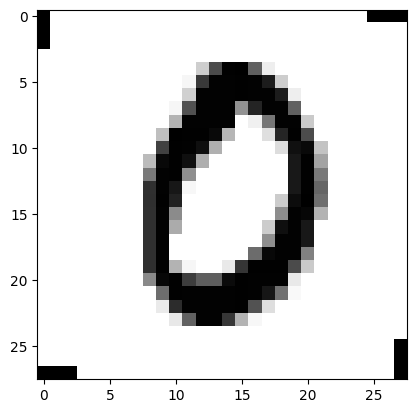

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [ ]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=False, download=True, transform=simple_transforms)
exp_data = exp.test_data
exp_data = exp.transform(exp_data.numpy())

print('[Test]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

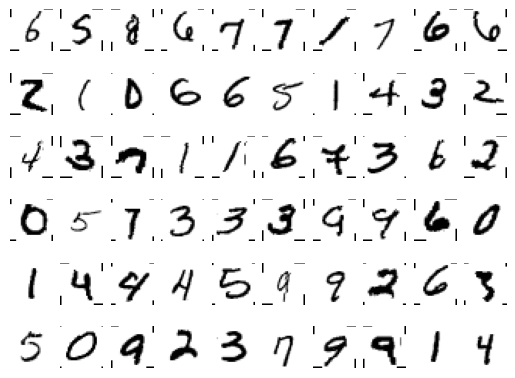

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
from models import Model10 as Net ,get_summary


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
device = torch.device("cuda" if cuda else "cpu")
model =  Net(dropout_value=0).to(device)
get_summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 10, 22, 22]             900
              ReLU-8           [-1, 10, 22, 22]               0
       BatchNorm2d-9           [-1, 10, 22, 22]              20
           Conv2d-10           [-1, 10, 20, 20]             900
      BatchNorm2d-11           [-1, 10, 20, 20]              20
           Conv2d-12           [-1, 10, 20, 20]             100
      BatchNorm2d-13           [-1, 10, 20, 20]              20
        MaxPool2d-14           [-1, 10,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm
from utils import train,test
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Let's Train and test our model

In [ ]:
model =  Net(dropout_value=0).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
step_val = int(len(train_loader)*1)   #938
print("step_val:" , step_val)
EPOCHS = 15
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=step_val, epochs=EPOCHS)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc_temp,train_losses_temp   = train(model, device, train_loader, optimizer, epoch,scheduler)
    test_acc_temp,test_losses_temp = test(model, device, test_loader)
    train_acc.extend(train_acc_temp)
    train_losses.extend(train_losses_temp)
    test_acc.extend(test_acc_temp)
    test_losses.extend(test_losses_temp)

step_val: 938
EPOCH: 0


Loss=0.3463079333305359 Batch_id=937 Accuracy=90.88: 100%|██████████| 938/938 [00:55<00:00, 16.92it/s]



Test set: Average loss: 0.1835, Accuracy: 9771/10000 (97.71%)

EPOCH: 1


Loss=0.05945558100938797 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:52<00:00, 17.76it/s]



Test set: Average loss: 0.0742, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.0416414774954319 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:48<00:00, 19.23it/s]



Test set: Average loss: 0.0571, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.07318775355815887 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:49<00:00, 19.08it/s]



Test set: Average loss: 0.0422, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.022737760096788406 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:47<00:00, 19.57it/s]



Test set: Average loss: 0.0437, Accuracy: 9892/10000 (98.92%)

EPOCH: 5


Loss=0.2618905305862427 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:49<00:00, 18.77it/s]



Test set: Average loss: 0.0330, Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.031083635985851288 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:47<00:00, 19.76it/s]



Test set: Average loss: 0.0319, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.016550371423363686 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:47<00:00, 19.70it/s]



Test set: Average loss: 0.0269, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.060482438653707504 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:50<00:00, 18.72it/s]



Test set: Average loss: 0.0248, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.04195719212293625 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:46<00:00, 20.08it/s]



Test set: Average loss: 0.0235, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.021813319995999336 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:48<00:00, 19.36it/s]



Test set: Average loss: 0.0228, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.058496978133916855 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:48<00:00, 19.28it/s]



Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.13311703503131866 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:51<00:00, 18.30it/s]



Test set: Average loss: 0.0206, Accuracy: 9952/10000 (99.52%)

EPOCH: 13


Loss=0.017857665196061134 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:47<00:00, 19.70it/s]



Test set: Average loss: 0.0200, Accuracy: 9950/10000 (99.50%)

EPOCH: 14


Loss=0.05147380381822586 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:48<00:00, 19.42it/s]



Test set: Average loss: 0.0195, Accuracy: 9956/10000 (99.56%)



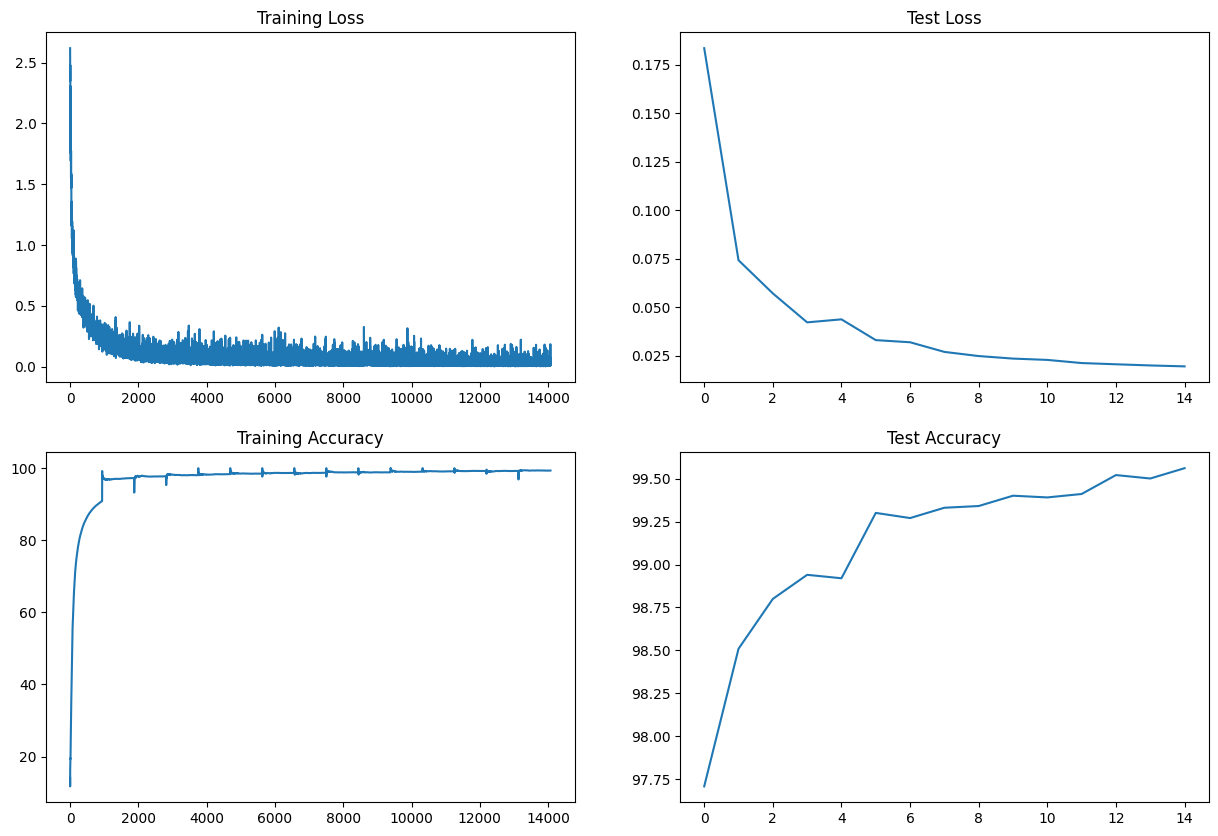

In [ ]:
from utils import plot_accuracy_losses,train,test
plot_accuracy_losses(train_losses,train_acc,test_losses,test_acc)